In [1]:
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2023-03-29 22:17:32.480657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 22:17:34.923078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/2022.10/envs/tf/lib/
2023-03-29 22:17:34.923332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/2022.10/envs/tf/lib/
2023-03-29 22:17:34.923340: W tensorflow/compiler/tf2ten

2.11.0


In [2]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Train shape: {train_images.shape}")
    print(f"Test shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels, class_names

train_images, train_labels, test_images, test_labels, class_names = load_data()

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [3]:
def preprocess_data(train_images, test_images):
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    return train_images, test_images

train_images, test_images = preprocess_data(train_images, test_images)

In [4]:
train_images_set = train_images[:(len(train_images)-(len(train_images)//5))]
train_labels_set = train_labels[:(len(train_labels)-(len(train_labels)//5))]

validation_images_set = train_images[(len(train_images)-(len(train_images)//5)):]
validation_labels_set = train_labels[(len(train_labels)-(len(train_labels)//5)):]

In [5]:
def plot_all_models(model_names, model_histories):
    # plot the validation and training loss in one plot, and the validation and training accuracy in another plot.
    # The y axis should be the loss or accuracy and be the same for each plot.
    # One plot only shows one model, so if there are 4 models, I should have 8 plots. 4 for loss and 4 for accuracy.
    # The x axis should be the epoch number.
    # The title of each plot should be the name of the model.
    # The legend should be the training and validation loss/accuracy.
    # The plots should be in the same figure.
    min_loss = 100
    max_loss = 0
    min_acc = 100
    max_acc = 0

    for history in model_histories:
        # set the minimum and maximum loss and accuracy
        # for the y axis of the plots
        # so that all plots will have the same y axis
        # and we can compare them
        if min(history.history['loss']) < min_loss:
            min_loss = min(history.history['loss'])
        if max(history.history['loss']) > max_loss:
            max_loss = max(history.history['loss'])
        if min(history.history['accuracy']) < min_acc:
            min_acc = min(history.history['accuracy'])
        if max(history.history['accuracy']) > max_acc:
            max_acc = max(history.history['accuracy'])
    delta_loss = max_loss - min_loss
    delta_acc = max_acc - min_acc
    min_loss = min_loss - delta_loss * 0.05
    max_loss = max_loss + delta_loss * 0.05
    min_acc = min_acc - delta_acc * 0.05
    max_acc = max_acc + delta_acc * 0.05

    for i in range(len(model_names)):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        fig.suptitle(f"Loss and accuracy for {model_names[i]}", fontsize=16)
        ax1.plot(model_histories[i].history['loss'], label='Training Loss')
        ax1.plot(model_histories[i].history['val_loss'], label='Validation Loss')
        ax1.set_title("Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_ylim([min_loss, max_loss])
        ax1.set_xlim([0, 15])
        ax1.set_xticks(np.arange(0, len(model_histories[i].history['loss']), 1))
        ax1.legend()

        ax2.plot(model_histories[i].history['accuracy'], label='Training Accuracy')
        ax2.plot(model_histories[i].history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title("Accuracy")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([min_acc, 1])
        ax2.set_xlim([0, 15])
        ax2.set_xticks(np.arange(0, len(model_histories[i].history['accuracy']), 1))
        ax2.legend()
        plt.tight_layout()
        plt.show()



# Choice 2: Decaying learning rate

In [6]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr

In [7]:
def create_model_baseline():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model


def train_model(train_images, train_labels , model, epochs=15, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, validation_data=(validation_images_set, validation_labels_set), epochs=epochs, batch_size=64, callbacks=[lr_decay, early_stopping])
    return model, history

### Baseline model

In [131]:
model_baseline = create_model_baseline()
model_baseline, history_baseline = train_model(train_images_set, train_labels_set, model_baseline)
model_baseline.save('model_baseline')

Epoch 1/15
750/750 [==============================] - 9s 9ms/step - loss: 0.5838 - accuracy: 0.7891 - val_loss: 0.4030 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3624 - accuracy: 0.8697 - val_loss: 0.3437 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3136 - accuracy: 0.8853 - val_loss: 0.3341 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 7ms/step - loss: 0.2825 - accuracy: 0.8962 - val_loss: 0.3105 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2580 - accuracy: 0.9058 - val_loss: 0.2752 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 7ms/step - loss: 0.2177 - accuracy: 0.9210 - val_loss: 0.2571 - val_accuracy: 0.9070 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 5s 7ms/step 

INFO:tensorflow:Assets written to: model_baseline/assets


INFO:tensorflow:Assets written to: model_baseline/assets


### Variant 1, Dropout

In [173]:
#Dropout inclussion after second maxpooling
#Dropout prevents overfitting by dropping a random weight (.5= 50% chance to happen)
#Dropout reduces correlation between neurons. It is added after second convolution layer before maxpolling since overfitting is most likely to happen there
def create_model_variant1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model


model_v1 = create_model_variant1()
model_v1, history_v1 = train_model(train_images_set, train_labels_set, model_v1)
model_v1.save('model_v1')
#Result: Dropout variant is both better than baseline on the test data and train data. A clear sign that the base model is slightly overfit.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2319 - accuracy: 0.9158 Variant1

Epoch 1/15


2023-03-28 21:43:45.414141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_50/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


750/750 [==============================] - 9s 9ms/step - loss: 0.5733 - accuracy: 0.7904 - val_loss: 0.4197 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3662 - accuracy: 0.8682 - val_loss: 0.3623 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3133 - accuracy: 0.8846 - val_loss: 0.3418 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2836 - accuracy: 0.8952 - val_loss: 0.3039 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2602 - accuracy: 0.9035 - val_loss: 0.3113 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2240 - accuracy: 0.9179 - val_loss: 0.2568 - val_accuracy: 0.9060 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2

INFO:tensorflow:Assets written to: model_v1/assets


INFO:tensorflow:Assets written to: model_v1/assets


### Variant 2, L1 regularization

In [136]:
#L1 Regularization: Added to dense layers
#L1 prevents overfitting by making the model use more weights that are set to 0
def create_model_variant2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)),
        tf.keras.layers.Dense(10, activation='softmax' , kernel_regularizer=tf.keras.regularizers.l1(0.001))
    ])
    return model

model_v2 = create_model_variant2()
model_v2, history_v2 = train_model(train_images_set, train_labels_set, model_v2)
model_v2.save('model_v2')

#Result: L1 performs better on the train data but has higher loss. This means its underfitting and will need more epochs to converge.
# In the test data it performs a bit worse than baseline.
# Different value for the strength could improve the results. In short it underfits compared to the baseline. Can't coverge fast enough in 15 epochs.
#Conclussion: loloss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.3358 - accuracy: 0.9046 Variant2

Epoch 1/15
750/750 [==============================] - 8s 9ms/step - loss: 1.1061 - accuracy: 0.7717 - val_loss: 0.7243 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 6s 8ms/step - loss: 0.6306 - accuracy: 0.8506 - val_loss: 0.5749 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 6s 8ms/step - loss: 0.5258 - accuracy: 0.8704 - val_loss: 0.4953 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 8ms/step - loss: 0.4686 - accuracy: 0.8802 - val_loss: 0.4446 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 6s 8ms/step - loss: 0.4364 - accuracy: 0.8866 - val_loss: 0.4429 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3834 - accuracy: 0.8985 - val_loss: 0.3974 - val_accuracy: 0.8892 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 6s 8ms/step 

INFO:tensorflow:Assets written to: model_v2/assets


INFO:tensorflow:Assets written to: model_v2/assets


### Variant 3, L2 regularization

In [140]:
#L2 Regularization: Adding to dense layers
#L2 prevents overfitting by slowly melting large weight values, encourages model to use lower weights
def create_model_variant3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    return model

model_v3 = create_model_variant3()
model_v3, history_v3 = train_model(train_images_set, train_labels_set, model_v3)
model_v3.save('model_v3')

#Result: L2 variant is a lot better than baseline on the train data but the accuracy seems better on the test data.
# It seems to converge faster however also appears to overfit since loss is higher on the test data.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2698 - accuracy: 0.9173 Variant3

Epoch 1/15
750/750 [==============================] - 8s 9ms/step - loss: 0.6604 - accuracy: 0.7892 - val_loss: 0.5148 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 7s 9ms/step - loss: 0.4339 - accuracy: 0.8682 - val_loss: 0.4051 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 7s 9ms/step - loss: 0.3743 - accuracy: 0.8847 - val_loss: 0.3701 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3394 - accuracy: 0.8935 - val_loss: 0.3518 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3134 - accuracy: 0.9028 - val_loss: 0.3399 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 7ms/step - loss: 0.2712 - accuracy: 0.9171 - val_loss: 0.3024 - val_accuracy: 0.9046 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 6s 8ms/step 

INFO:tensorflow:Assets written to: model_v3/assets


INFO:tensorflow:Assets written to: model_v3/assets


### Variant 4, Batch normalization

In [193]:
#Batch normalization: After first Conv2D layer 
#Stabilize learning process. Normalizes values to 0 or to 1 depending on whichever they are closer to using mean and std, solves internal covariate shift.
def create_model_variant4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model_v4 = create_model_variant4()
model_v4, history_v4 = train_model(train_images_set, train_labels_set, model_v4)
model_v4.save('model_v4')

#Result: Batch normalization trains excelently BUT will need more epochs to improve validation accuracy. Seems to overfit.
#This variant could also largely improve by adding a dropping layer and regulizers to reduce overfitting (but we can only have 1 change per variant).
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.4109 - accuracy: 0.9140 Variant3

Epoch 1/15
750/750 [==============================] - 9s 10ms/step - loss: 0.4690 - accuracy: 0.8335 - val_loss: 0.3643 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3102 - accuracy: 0.8899 - val_loss: 0.3267 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 6s 9ms/step - loss: 0.2686 - accuracy: 0.9031 - val_loss: 0.3061 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2373 - accuracy: 0.9139 - val_loss: 0.3079 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 7s 9ms/step - loss: 0.2149 - accuracy: 0.9217 - val_loss: 0.2934 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 8ms/step - loss: 0.1617 - accuracy: 0.9402 - val_loss: 0.2605 - val_accuracy: 0.9089 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 6s 8ms/step

INFO:tensorflow:Assets written to: model_v4/assets


INFO:tensorflow:Assets written to: model_v4/assets


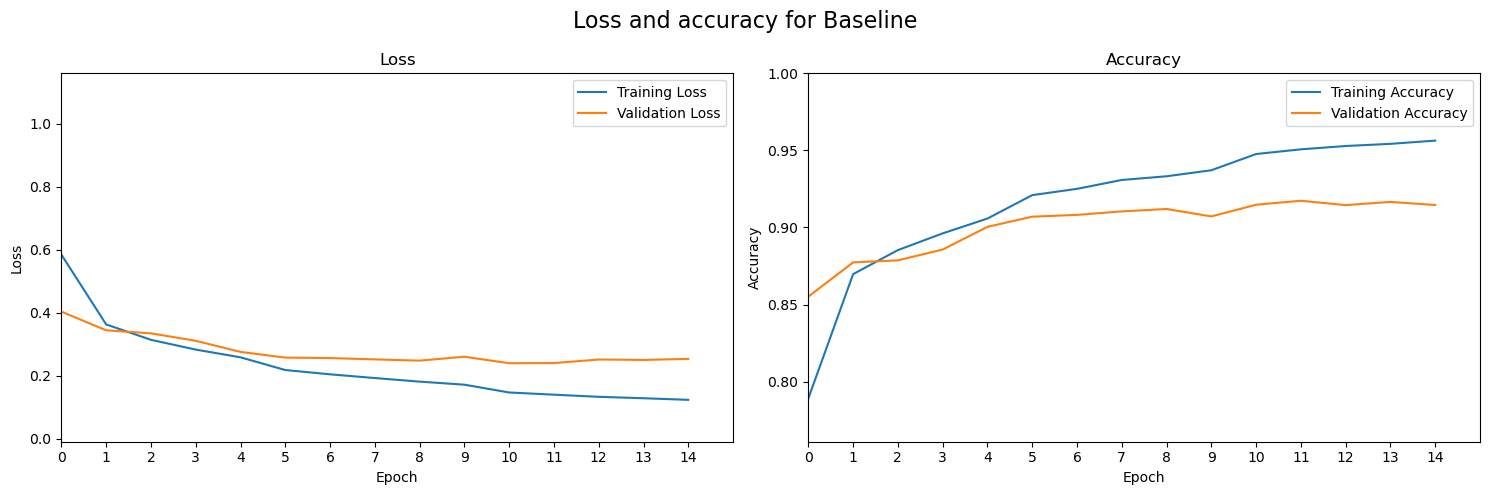

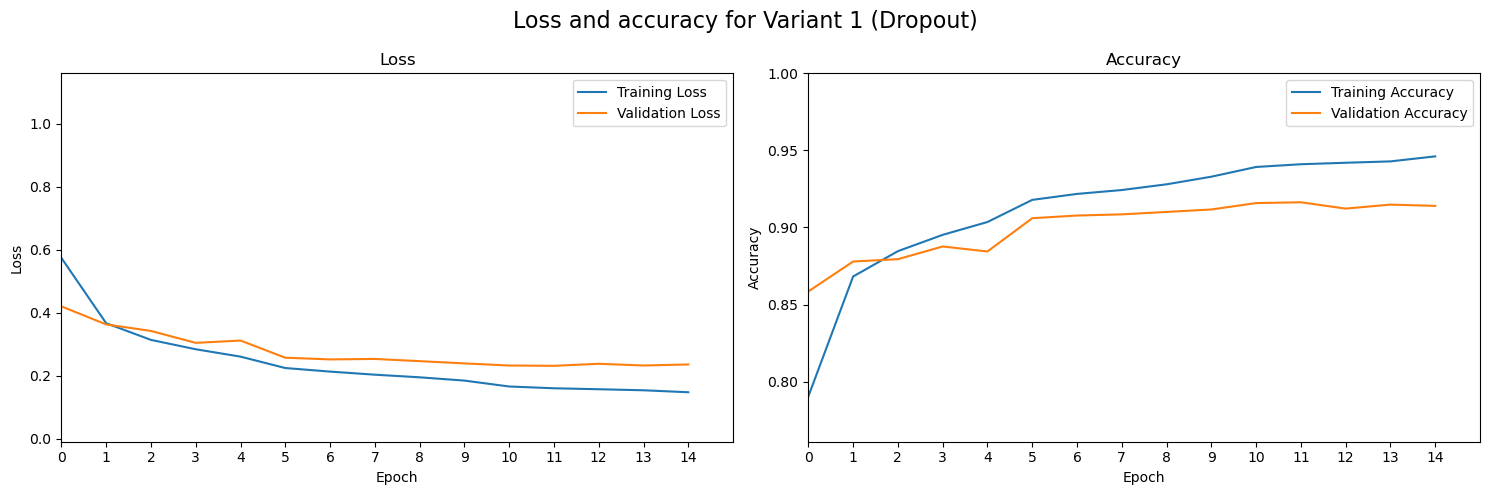

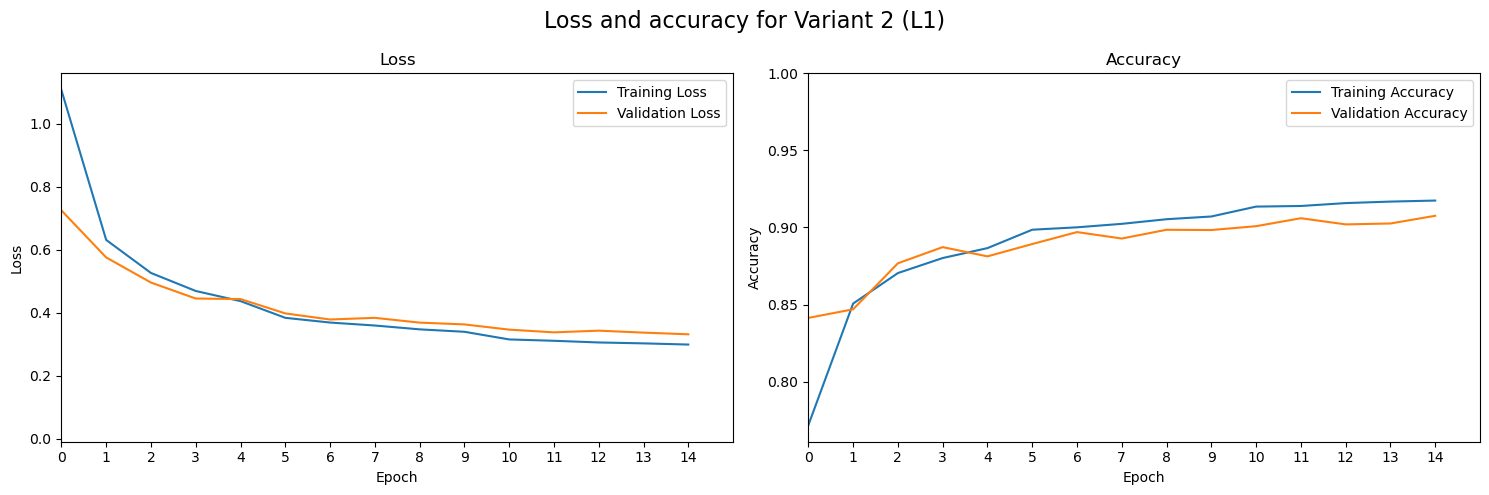

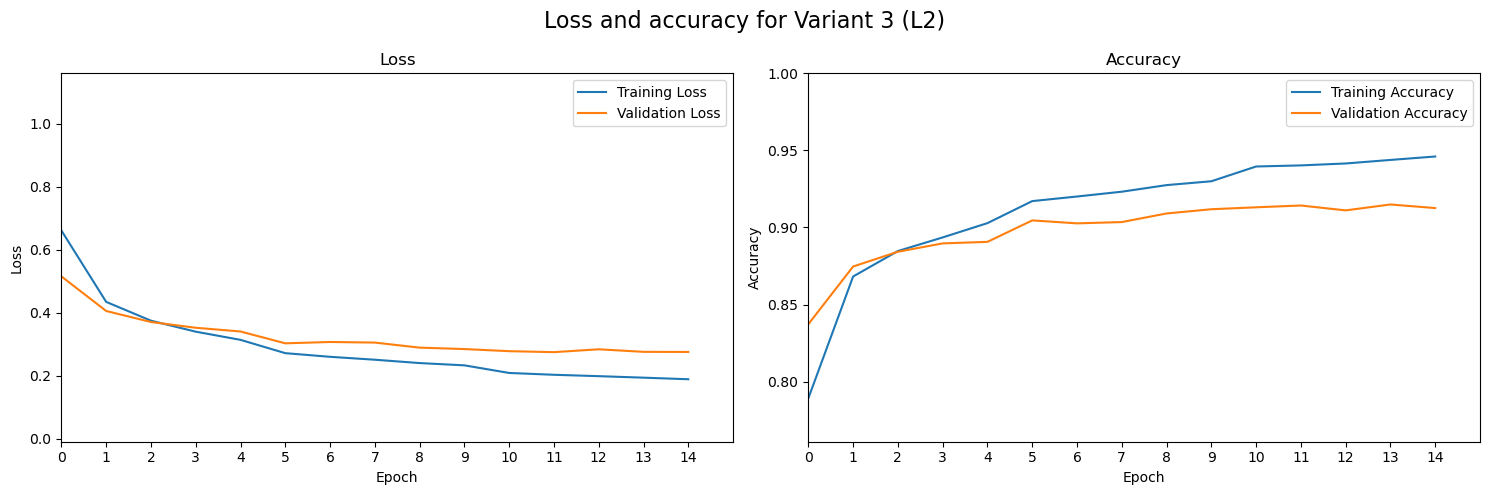

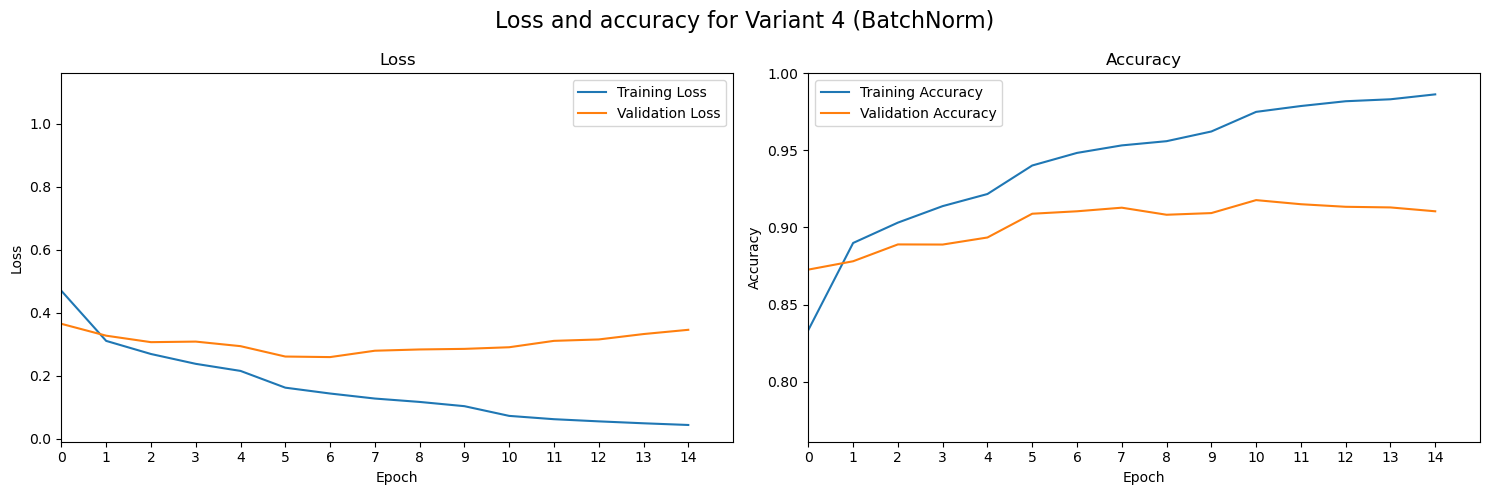

In [196]:
histories = [history_baseline, history_v1, history_v2, history_v3, history_v4]
model_names = ['Baseline', 'Variant 1 (Dropout)', 'Variant 2 (L1)', 'Variant 3 (L2)', 'Variant 4 (BatchNorm)']

plot_all_models(model_names, histories)

In [198]:
#Two Best performing CNNs

model1Base = create_model_baseline()
model2Batch = create_model_variant4()

model1Base, historyBase = train_model(train_images, train_labels, model1Base)
model2Batch, historyBatch = train_model(train_images, train_labels, model2Batch)


Epoch 1/15
938/938 [==============================] - 12s 10ms/step - loss: 0.4614 - accuracy: 0.8346 - val_loss: 0.3162 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 9s 9ms/step - loss: 0.3002 - accuracy: 0.8906 - val_loss: 0.2729 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 10s 11ms/step - loss: 0.2597 - accuracy: 0.9051 - val_loss: 0.2294 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2310 - accuracy: 0.9148 - val_loss: 0.2527 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2082 - accuracy: 0.9235 - val_loss: 0.2007 - val_accuracy: 0.9273 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 9s 9ms/step - loss: 0.1570 - accuracy: 0.9414 - val_loss: 0.1482 - val_accuracy: 0.9445 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 8s 9ms/s

In [197]:
# Evaluate the model1
test_loss_base, test_acc_base = model1Base.evaluate(test_images, test_labels, verbose=1)

print(f"model1Base: Test accuracy: {test_acc_base}")
print(f"model1Base: Test loss: {test_loss_base}")


# Evaluate the model2
test_loss_batch, test_acc_batch = model2Batch.evaluate(test_images, test_labels, verbose=1)

print(f"model2Batch: Test accuracy: {test_acc_batch}")
print(f"model2Batch: Test loss: {test_loss_batch}")

313/313 [==============================] - 2s 5ms/step - loss: 0.2650 - accuracy: 0.9178
model1Base: Test accuracy: 0.9178000092506409
model1Base: Test loss: 0.26501351594924927
313/313 [==============================] - 2s 5ms/step - loss: 0.4229 - accuracy: 0.9080
model2Batch: Test accuracy: 0.9079999923706055
model2Batch: Test loss: 0.4229421317577362


# Choice 1: Confusion Matrix

313/313 [==============================] - 1s 3ms/step
Normalized confusion matrix
[[0.884 0.    0.022 0.011 0.003 0.    0.074 0.    0.006 0.   ]
 [0.001 0.979 0.002 0.013 0.002 0.    0.001 0.    0.002 0.   ]
 [0.015 0.    0.887 0.006 0.043 0.    0.046 0.    0.003 0.   ]
 [0.012 0.003 0.011 0.93  0.026 0.    0.016 0.    0.002 0.   ]
 [0.001 0.001 0.04  0.023 0.877 0.    0.055 0.    0.003 0.   ]
 [0.    0.    0.    0.    0.    0.981 0.    0.012 0.    0.007]
 [0.12  0.001 0.059 0.023 0.064 0.    0.725 0.    0.008 0.   ]
 [0.    0.    0.    0.    0.    0.01  0.    0.985 0.    0.005]
 [0.002 0.    0.003 0.003 0.002 0.001 0.004 0.001 0.984 0.   ]
 [0.    0.    0.    0.    0.    0.007 0.    0.047 0.    0.946]]


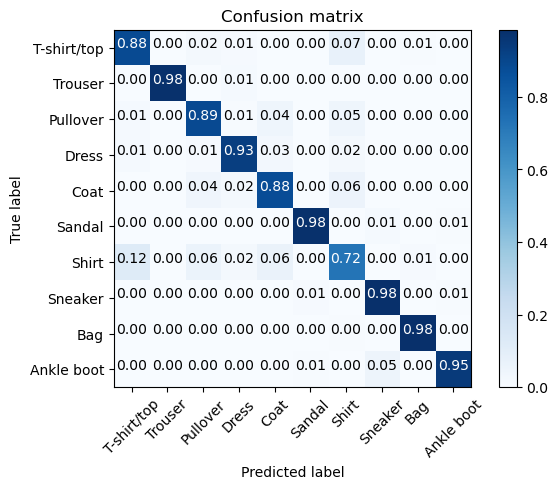

In [194]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_pred = model1Base.predict(test_images)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = test_labels
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plot_confusion_matrix(confusion_mtx, class_names, normalize=True, title='Confusion matrix')

# Choice 3: k-fold cross-validation

In [12]:
# from sklearn.model_selection import StratifiedKFold

# # k fold cross validation with average weight saving
# def k_fold_cross_validation(k, train_images, train_labels, create_model=create_model_baseline, epochs=10, batch_size=64):
#     all_scores = []
#     all_histories = []
#     all_weights = []
#     kfold = StratifiedKFold(n_splits=k, shuffle=True)
#     for train, test in kfold.split(train_images, train_labels):
#         model = create_model()
#         opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#         lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
#         model.compile(optimizer=opt,
#                     loss='sparse_categorical_crossentropy',
#                     metrics=['accuracy'])
#         history = model.fit(train_images[train], train_labels[train], epochs=10, batch_size=64, validation_data=(train_images[test], train_labels[test]), callbacks=[lr_decay])
#         scores = model.evaluate(train_images[test], train_labels[test], verbose=0)
#         print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#         all_scores.append(scores[1] * 100)
#         all_histories.append(history)
#         all_weights.append(model.get_weights())
#     return all_scores, all_histories, all_weights


def k_fold_cross_validation(k, train_images, train_labels, learning_rate=0.001, create_model=create_model_baseline, num_epochs=15, batch_size=64, metrics=['accuracy'], verbose=0):
    num_val_samples = len(train_images) // k
    val_accuracies = []
    val_losses = []
    histories = []
    all_weights = []
    for i in range(k):
        print(f"Processing fold #{i}", end=" ")
        val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_images[:i * num_val_samples],
            train_images[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_labels[:i * num_val_samples],
            train_labels[(i + 1) * num_val_samples:]],
            axis=0)
        model = create_model()
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        model.compile(optimizer=opt,
                    loss='sparse_categorical_crossentropy',
                    metrics=metrics)
        history = model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=[lr_decay])
        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        print(f"val_acc: {val_acc}, val_loss: {val_loss} - train_acc: {history.history['accuracy'][-1]}, train_loss: {history.history['loss'][-1]}")
        histories.append(history)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        all_weights.append(model.get_weights())
    return histories, val_accuracies, val_losses, all_weights


In [13]:
histories, val_acc, val_loss, all_weights = k_fold_cross_validation(10, train_images, train_labels)

Processing fold #0 val_acc: 0.9151666760444641, val_loss: 0.2430700957775116 - train_acc: 0.9580925703048706, train_loss: 0.11566893011331558
Processing fold #1 val_acc: 0.9193333387374878, val_loss: 0.22790946066379547 - train_acc: 0.958814799785614, train_loss: 0.11410137265920639
Processing fold #2 val_acc: 0.9086666703224182, val_loss: 0.26621174812316895 - train_acc: 0.9578333497047424, train_loss: 0.11695466935634613
Processing fold #3 val_acc: 0.9144999980926514, val_loss: 0.2620702385902405 - train_acc: 0.9583518505096436, train_loss: 0.1174878254532814
Processing fold #4 val_acc: 0.9154999852180481, val_loss: 0.24961625039577484 - train_acc: 0.9578333497047424, train_loss: 0.11730456352233887
Processing fold #5 val_acc: 0.9185000061988831, val_loss: 0.24269862473011017 - train_acc: 0.954537034034729, train_loss: 0.12751483917236328
Processing fold #6 val_acc: 0.9146666526794434, val_loss: 0.25828227400779724 - train_acc: 0.9547777771949768, train_loss: 0.12674261629581451
Proc

In [28]:
def plot_k_fold_cross_validation_accuracy(val_accuracies):
    # bar chart of accuracy
    min = np.min(val_accuracies)
    max = np.max(val_accuracies)
    delta = max - min
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('k-fold cross-validation accuracy scores')
    ax1.bar(range(len(val_accuracies)), val_accuracies)
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(min - delta * 0.1, max + delta * 0.1)
    ax1.set_xticks(range(len(val_accuracies)))
    
    sns.boxplot(val_accuracies)
    ax2.set_xlabel('10 folds')
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks([])
    plt.show()


def plot_k_fold_cross_validation_loss(val_losses):
    min = np.min(val_losses)
    max = np.max(val_losses)
    delta = max - min
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('k-fold cross-validation loss scores')
    ax1.bar(range(len(val_losses)), val_losses)
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Loss')
    ax1.set_ylim(min - delta * 0.1, max + delta * 0.1)
    ax1.set_xticks(range(len(val_losses)))
    

    sns.boxplot(val_losses)
    ax2.set_xlabel('10 folds')
    ax2.set_ylabel('Loss')
    ax2.set_xticks([])
    plt.show()

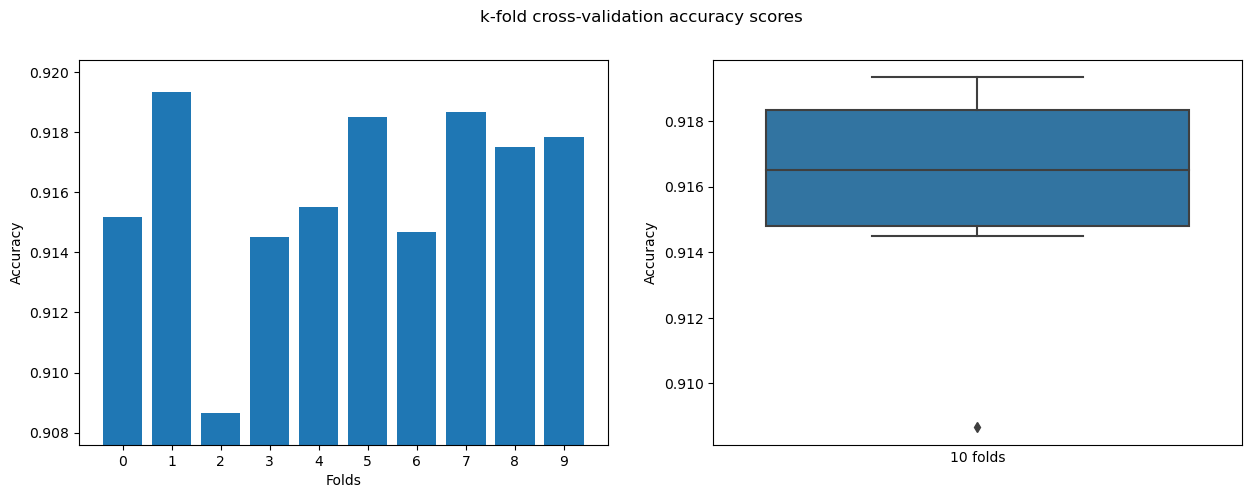

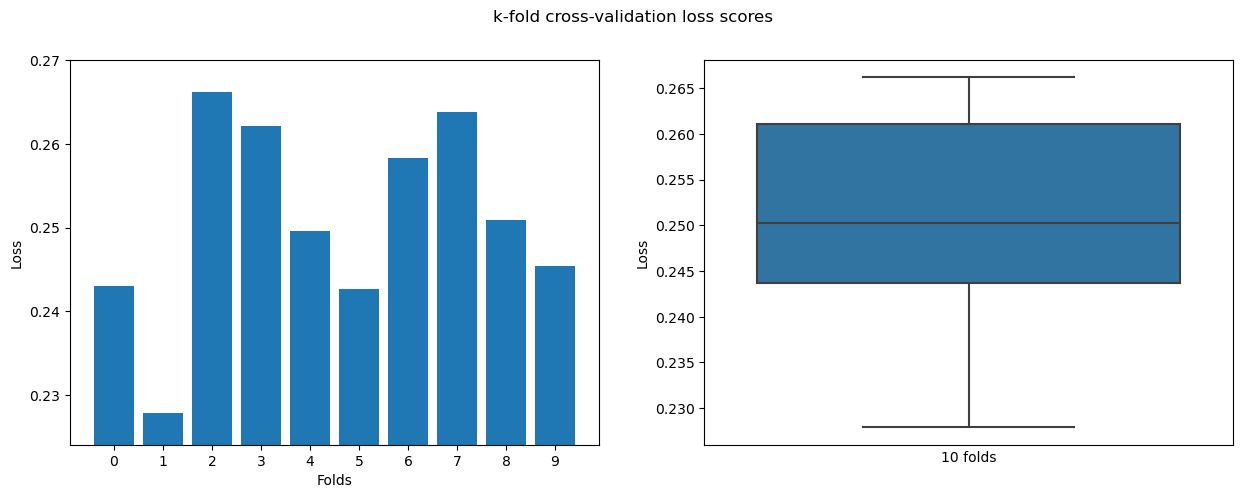

Average accuracy: 0.9160333335399627
Average loss: 0.25100241899490355


In [29]:
plot_k_fold_cross_validation_accuracy(val_acc)
plot_k_fold_cross_validation_loss(val_loss)

print(f"Average accuracy: {np.mean(val_acc)}")
print(f"Average loss: {np.mean(val_loss)}")

# Choice 6: Other dataset

In [204]:
import cv2
import pandas as pd

def pad_image(image):
    height, width = image.shape
    if height > width:
        padding = (height - width) // 2
        image = cv2.copyMakeBorder(image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    elif width > height:
        padding = (width - height) // 2
        image = cv2.copyMakeBorder(image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return image


def get_image_by_id(id):
    try:
        image = cv2.imread("images/" + str(id) + ".jpg", cv2.IMREAD_GRAYSCALE)
        image = pad_image(image)
        image = cv2.resize(image, (28, 28))
        return image
    except Exception as e:
        print("Error loading image with id: " + str(id))
        print(e)
        return None

def get_image_by_ids(ids):
    images = []
    for id in ids:
        image = get_image_by_id(id)
        if image is not None:
            images.append(image)
    return np.array(images)

In [212]:
df = pd.read_csv("styles.csv", on_bad_lines='skip')
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
sub_categories = df['subCategory'].unique()
article_types = df['articleType'].unique()
article_types

array(['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks',
       'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra',
       'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant',
       'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas',
       'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees',
       'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests',
       'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket',
       'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring',
       'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers',
       'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta',
       'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics',
       'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser',
       'Necklace and Chains', 'Duffel Bag', 'Sports Sandals',
       'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag',
       'Tracksuits', 'S